N.B. In this notebook I implement the Capstone project, which is a peer-graded assignment, of the course "Machine learning with Python". This course was developed by IBM Skills Network and is offered on Coursera. 

# Problem setup

<b> Problem: </b>    predict whether a loan will be paid off or not using dataset ''Loan_train.csv''

<b> Solution: </b>   build a classifier

<b> Strategy: </b>  load and clean dataset, build different models, compare their accuracies using different metrics and select best model

<b> Models considered: </b> 
    - k-Nearest Neighbour           clf_neigh
    - Decision Tree                 clf_tree
    - Support Vector Machine        clf_svm
    - Logistic Regression           clf_lg

<b> Metrics considered: </b> 
    - Jaccard index
    - F1-score
    - LogLoss
    
<b> Dataset description: </b>     

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

# Necessary libraries

Importing essential libraries, modules and functions

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


# Preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.metrics import jaccard_score, confusion_matrix, f1_score, log_loss

# Machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, svm
from sklearn.linear_model import LogisticRegression

# Preprocessing of data and feature selection

For convenience, let's set up a completely numerical dataframe.
    - df: pandas dataframe with all original data, both numerical and categorical.
    - pdf: pandas dataframe with selected features from df, numerical and normalized with StandardScaler. 

## Load dataset

Importing the data

In [15]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-08-28 11:11:07--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

     0K .......... .......... ..                              100% 1.66M=0.01s

2022-08-28 11:11:09 (1.66 MB/s) - 'loan_train.csv' saved [23101/23101]



Reading the data and creating a dataframe

In [16]:
df = pd.read_csv('loan_train.csv')

## Checking dataset

Now let's check how is this data organized, if there are missing values, extra features, missing features.

In [17]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [18]:
df.shape

(346, 10)

Let's check if there is any missing data

In [19]:
set(df.isna().values.flat)

{False}

It's a small dataset, with seemingly no missing data. But the two columns containing dates have string objects, so let's make them proper time objects. 

In [20]:
df.loc[0, 'effective_date']

'9/8/2016'

In [21]:
df['effective_date'] = pd.to_datetime(df.effective_date)
df['due_date'] = pd.to_datetime(df.due_date)

In [22]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [23]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [24]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

Let us fix the typo in the word Bechalor and capitalize the word college for consistency.

In [25]:
df['education'] = df['education'].replace(['Bechalor', 'college'], ['Bachelor', 'College'])
df['education'] 

0      High School or Below
1                  Bachelor
2                   College
3                   College
4                   College
               ...         
341    High School or Below
342    High School or Below
343                 College
344                 College
345                 College
Name: education, Length: 346, dtype: object

TODO: analyse outliers.

## Feature selection

Let's take a look at what's going on between the features and the target variable

In [26]:
def relation_with(numerical_feature, categorical_feature, n_bins=10, col_wrap=None, df=df):
    if col_wrap == None:
        col_wrap = len(set(df[categorical_feature].unique().flat))
    bins = np.linspace(df[numerical_feature].min(), df[numerical_feature].max(), n_bins)
    g = sns.FacetGrid(df, col=categorical_feature, hue="loan_status", palette=['forestgreen','red'],col_wrap=col_wrap)
    g.map(plt.hist, numerical_feature, bins=bins, ec="k")
    g.axes[-1].legend()
    plt.show()

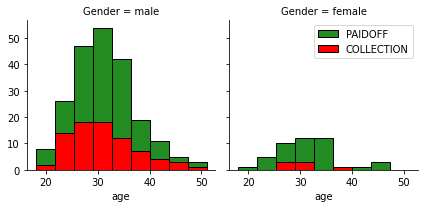

In [27]:
relation_with('age', 'Gender')

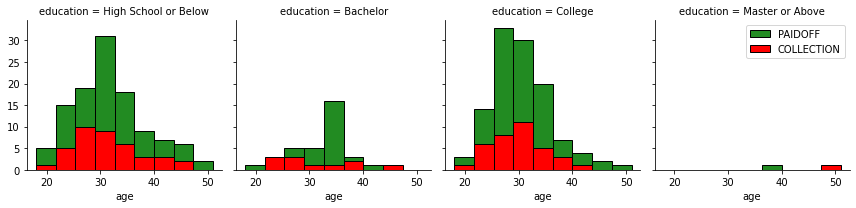

In [28]:
relation_with('age', 'education')

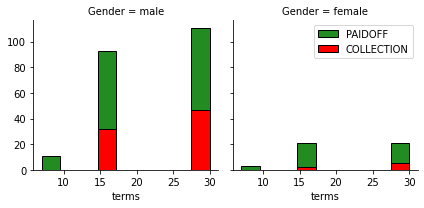

In [29]:
relation_with('terms', 'Gender')

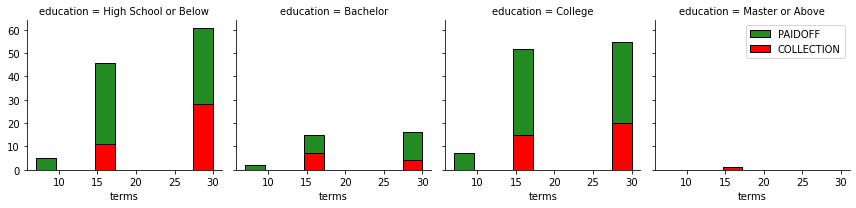

In [30]:
relation_with('terms', 'education')

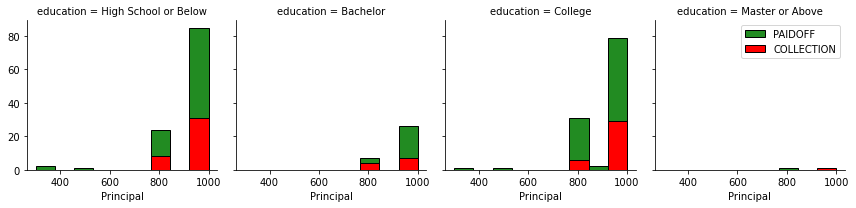

In [31]:
relation_with('Principal', 'education')

- It looks like people in their 30's have a higher probability of paying it off. 

- From the plots above, I am not sure how 'terms' impact the target. 

- It is worth noting that most people fall in the education classes 'High School or Below' or 'College'.

If we look at education, we must be careful in the normalization. It may look, a priory, that 'Master or Above' have a lower probability of pay off:

In [32]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bachelor              PAIDOFF        0.750000
                      COLLECTION     0.250000
College               PAIDOFF        0.765101
                      COLLECTION     0.234899
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
Name: loan_status, dtype: float64

But that information is meaningless since we only have data on 2 people in that class. Without normalizing, we see it:

In [33]:
df.groupby(['education'])['loan_status'].value_counts(normalize=False)

education             loan_status
Bachelor              PAIDOFF         33
                      COLLECTION      11
College               PAIDOFF        114
                      COLLECTION      35
High School or Below  PAIDOFF        112
                      COLLECTION      39
Master or Above       COLLECTION       1
                      PAIDOFF          1
Name: loan_status, dtype: int64

There are also many more 'male' than 'female', but not as absurd.

In [34]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

The goal is to create a classifier to predict, given certain features, if a client will pay the loan or not. Such a classifier may auxiliate in deciding which loans should be provided. Depending on the model, we may predict the probability that the loan_status will be "PAIDOFF" or "COLLECTION".

What are the features we may take into account?

To answer that we must undertand how each feature relates with the target variable.

In [35]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

In [36]:
set((df['Unnamed: 0']==df['Unnamed: 0.1']).values.flat)

{True}

The first two columns are equal and it looks like 'Unnamed: 0' is simply an ID, with some observations already filtered. So, let's drop them. And let's also drop the target feature.

In [37]:
pdf = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status'], axis=1)
pdf

,Principal,terms,effective_date,due_date,age,education,Gender
0,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,1000,30,2016-09-08,2016-10-07,33,Bachelor,female
2,1000,15,2016-09-08,2016-09-22,27,College,male
3,1000,30,2016-09-09,2016-10-08,28,College,female
4,1000,30,2016-09-09,2016-10-08,29,College,male
...,...,...,...,...,...,...,...
341,800,15,2016-09-11,2016-09-25,32,High School or Below,male
342,1000,30,2016-09-11,2016-10-10,25,High School or Below,male
343,800,15,2016-09-12,2016-09-26,39,College,male
344,1000,30,2016-09-12,2016-11-10,28,College,male


In [38]:
set((df['Principal']).values.flat)

{300, 500, 800, 900, 1000}

In [39]:
set((df['terms']).values.flat)

{7, 15, 30}

Let us consider the difference between 'effective_date' and 'due_date', which we shall call 'duration', and its relation with 'Terms'. The quantity duration/terms gives the number of payments done. 

OBS: there are other features that can be obtained from the time data that could be considered. 

In [40]:
set((df['due_date'] - df['effective_date']).astype('timedelta64[D]').values.flat)

{6.0, 13.0, 14.0, 29.0, 44.0, 59.0}

In [41]:
df['duration'] = ((df['due_date'] - df['effective_date']).astype('timedelta64[D]')).astype(int)
pdf['duration'] = ((df['due_date'] - df['effective_date']).astype('timedelta64[D]')).astype(int)

and we may drop 'effective_date' and 'due_date' in this analysis, since we reduced them to 'duration'

In [42]:
pdf.drop(['effective_date', 'due_date'], axis=1, inplace=True)

In [43]:
set(df.education.values.flat)

{'Bachelor', 'College', 'High School or Below', 'Master or Above'}

In [44]:
pdf['npayments'] = round(df['duration']/df['terms']) 
df['npayments'] = pdf['npayments']
pdf['npayments'].value_counts()

1.0    322
2.0     19
3.0      5
Name: npayments, dtype: int64

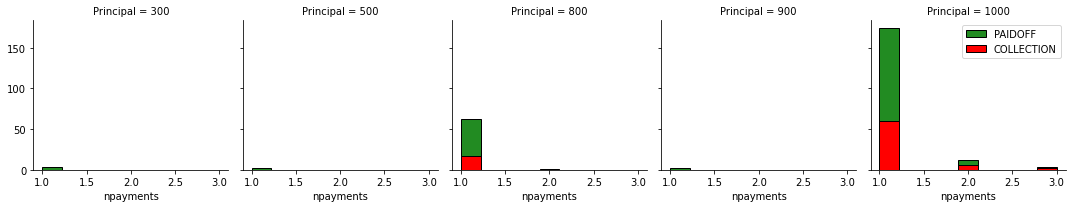

In [45]:
relation_with('npayments', 'Principal')

In [46]:
df.groupby(['npayments'])['loan_status'].value_counts(normalize=True)

npayments  loan_status
1.0        PAIDOFF        0.760870
           COLLECTION     0.239130
2.0        PAIDOFF        0.631579
           COLLECTION     0.368421
3.0        PAIDOFF        0.600000
           COLLECTION     0.400000
Name: loan_status, dtype: float64

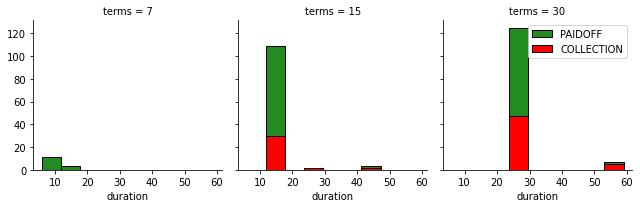

In [47]:
relation_with('duration', 'terms')

To use 'education' 

In [48]:
pdf['education'].replace(['High School or Below','College', 'Bachelor', 'Master or Above'], [0, 1,2,3], inplace=True)

In [49]:
set(df.Gender.values.flat)

{'female', 'male'}

In [50]:
pdf['Gender'].replace(['female', 'male'], [0, 1], inplace=True)

In [51]:
pdf

,Principal,terms,age,education,Gender,duration,npayments
0,1000,30,45,0,1,29,1.0
1,1000,30,33,2,0,29,1.0
2,1000,15,27,1,1,14,1.0
3,1000,30,28,1,0,29,1.0
4,1000,30,29,1,1,29,1.0
...,...,...,...,...,...,...,...
341,800,15,32,0,1,14,1.0
342,1000,30,25,0,1,29,1.0
343,800,15,39,1,1,14,1.0
344,1000,30,28,1,1,59,2.0


In [52]:
df

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,duration,npayments
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,29,1.0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,female,29,1.0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,College,male,14,1.0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,College,female,29,1.0
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,College,male,29,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
341,394,394,COLLECTION,800,15,2016-09-11,2016-09-25,32,High School or Below,male,14,1.0
342,395,395,COLLECTION,1000,30,2016-09-11,2016-10-10,25,High School or Below,male,29,1.0
343,397,397,COLLECTION,800,15,2016-09-12,2016-09-26,39,College,male,14,1.0
344,398,398,COLLECTION,1000,30,2016-09-12,2016-11-10,28,College,male,59,2.0


## Features set and target

The dataframe pdf contains only the desired features and they are all numerical. Let's standardize!

In [53]:
X_num = preprocessing.StandardScaler().fit(pdf).transform(pdf)
y_num = df.loan_status.replace(['COLLECTION', 'PAIDOFF'], [0, 1])

y_cat = df.loan_status
X_numcat = df[pdf.columns]

Now we are good to go!

# Building different models

In this section we build the models:
    - k-Nearest Neighbour
    - Decision Tree
    - Support Vector Machine
    - Logistic Regression

In [54]:
random_state = 1993

## K-nearest neighbors

### Build model for several k's and choose k for best fit

Let us build a classifier for several k's and choose best value based on resulting accuracies
 

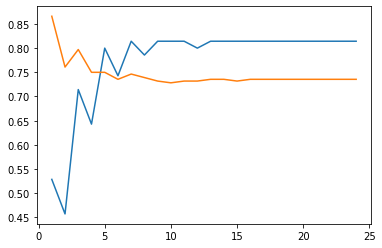

In [58]:
# Features and target sets
X = X_num
y = y_cat

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

# Iteration: build model with several k's
accuracy_train = []
accuracy_test = []

kvalues = range(1,25)
for k in kvalues:
    neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)

    # Make predictions using model and test set
    y_predictions = neigh.predict(X_test)

    # Evaluate accuary of predictions using Jaccard distance
    accuracy_train.append(metrics.accuracy_score(y_train,neigh.predict(X_train)))
    accuracy_test.append(metrics.accuracy_score(y_test,y_predictions))

# Visualize dependence of accucary w.r.t k
plt.plot(kvalues,accuracy_test)
plt.plot(kvalues,accuracy_train)

From the above, a suitable value to choose is k=5.

### Model and Accuracy measures for k = 5

In [93]:
# Features and target sets
X = X_num
y = y_cat

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

# Train model for k=5
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)
y_predictions = neigh.predict(X_test)
y_probabilities = neigh.predict_proba(X_test)

# Accuracy metrics
KNN_accuracy = {'Jaccard'  : jaccard_score(y_test, y_predictions, pos_label='PAIDOFF'),
                'F1 score' : f1_score(y_test, y_predictions, pos_label='PAIDOFF'),
                'Log loss' : 'NA'}
print(KNN_accuracy)

{'Jaccard': 0.8142857142857143, 'F1 score': 0.8976377952755905, 'Log loss': 'NA'}


To interpret our model, let us check out the resulting confusion matrix

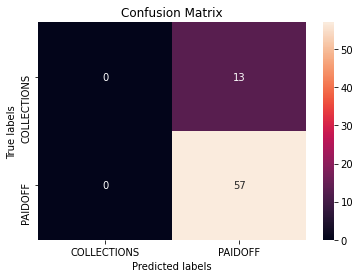

In [66]:
cm = confusion_matrix(y_test, y_predictions)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COLLECTIONS', 'PAIDOFF']); ax.yaxis.set_ticklabels(['COLLECTIONS', 'PAIDOFF']);

A priori it doesn't look so bad (though I still have to gain intuition in this kind of analysis)..
Yet, it seems a large number of predicted PAIDOFF were actually COLLECTIONS. Maybe a model that is inclined to be less precise in the other direction is better. That is, high accuracy when giving loans. 

How could we improve it to obtain higher accuracy in predicting PAYDOFF?
 - Could we simply change k? Preliminary tests indicate that changing k does not decrease the wrong paydoff predictions.
 - Try a different algorithm? We shall check this. 
 - Choose different features? Study the impact of each feature? This would be an intricate analysis and shall not be performed in this notebook.
 - Check literature: people might have done similar analysis and might have tips in best path from here. 

## Decision Tree

### Build model for several max_depths and choose best fit

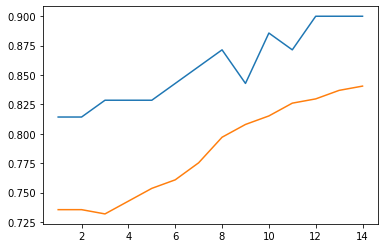

In [67]:
# Features and target sets
X = X_num
y = df.loan_status

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

# Iteration: Build model with several max_depths
accuracy_test = []
accuracy_train = []

max_depth_values = range(1,15)
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth = max_depth)
    clf = clf.fit(X, y)
    predTree = clf.predict(X_test)
    accuracy_test.append(metrics.accuracy_score(y_test, predTree))
    accuracy_train.append(metrics.accuracy_score(y_train, clf.predict(X_train)))

# Visualize dependence of accucary w.r.t k
plt.plot(max_depth_values,accuracy_test)
plt.plot(max_depth_values,accuracy_train)

### Model and accuracy metrics for max_depths=7

{'Jaccard': 0.8461538461538461, 'F1 score': 0.9166666666666667, 'Log loss': 'NA'}

DecisionTrees's Test set Accuracy:  0.8571428571428571
DecisionTrees's Train set Accuracy:  0.7753623188405797


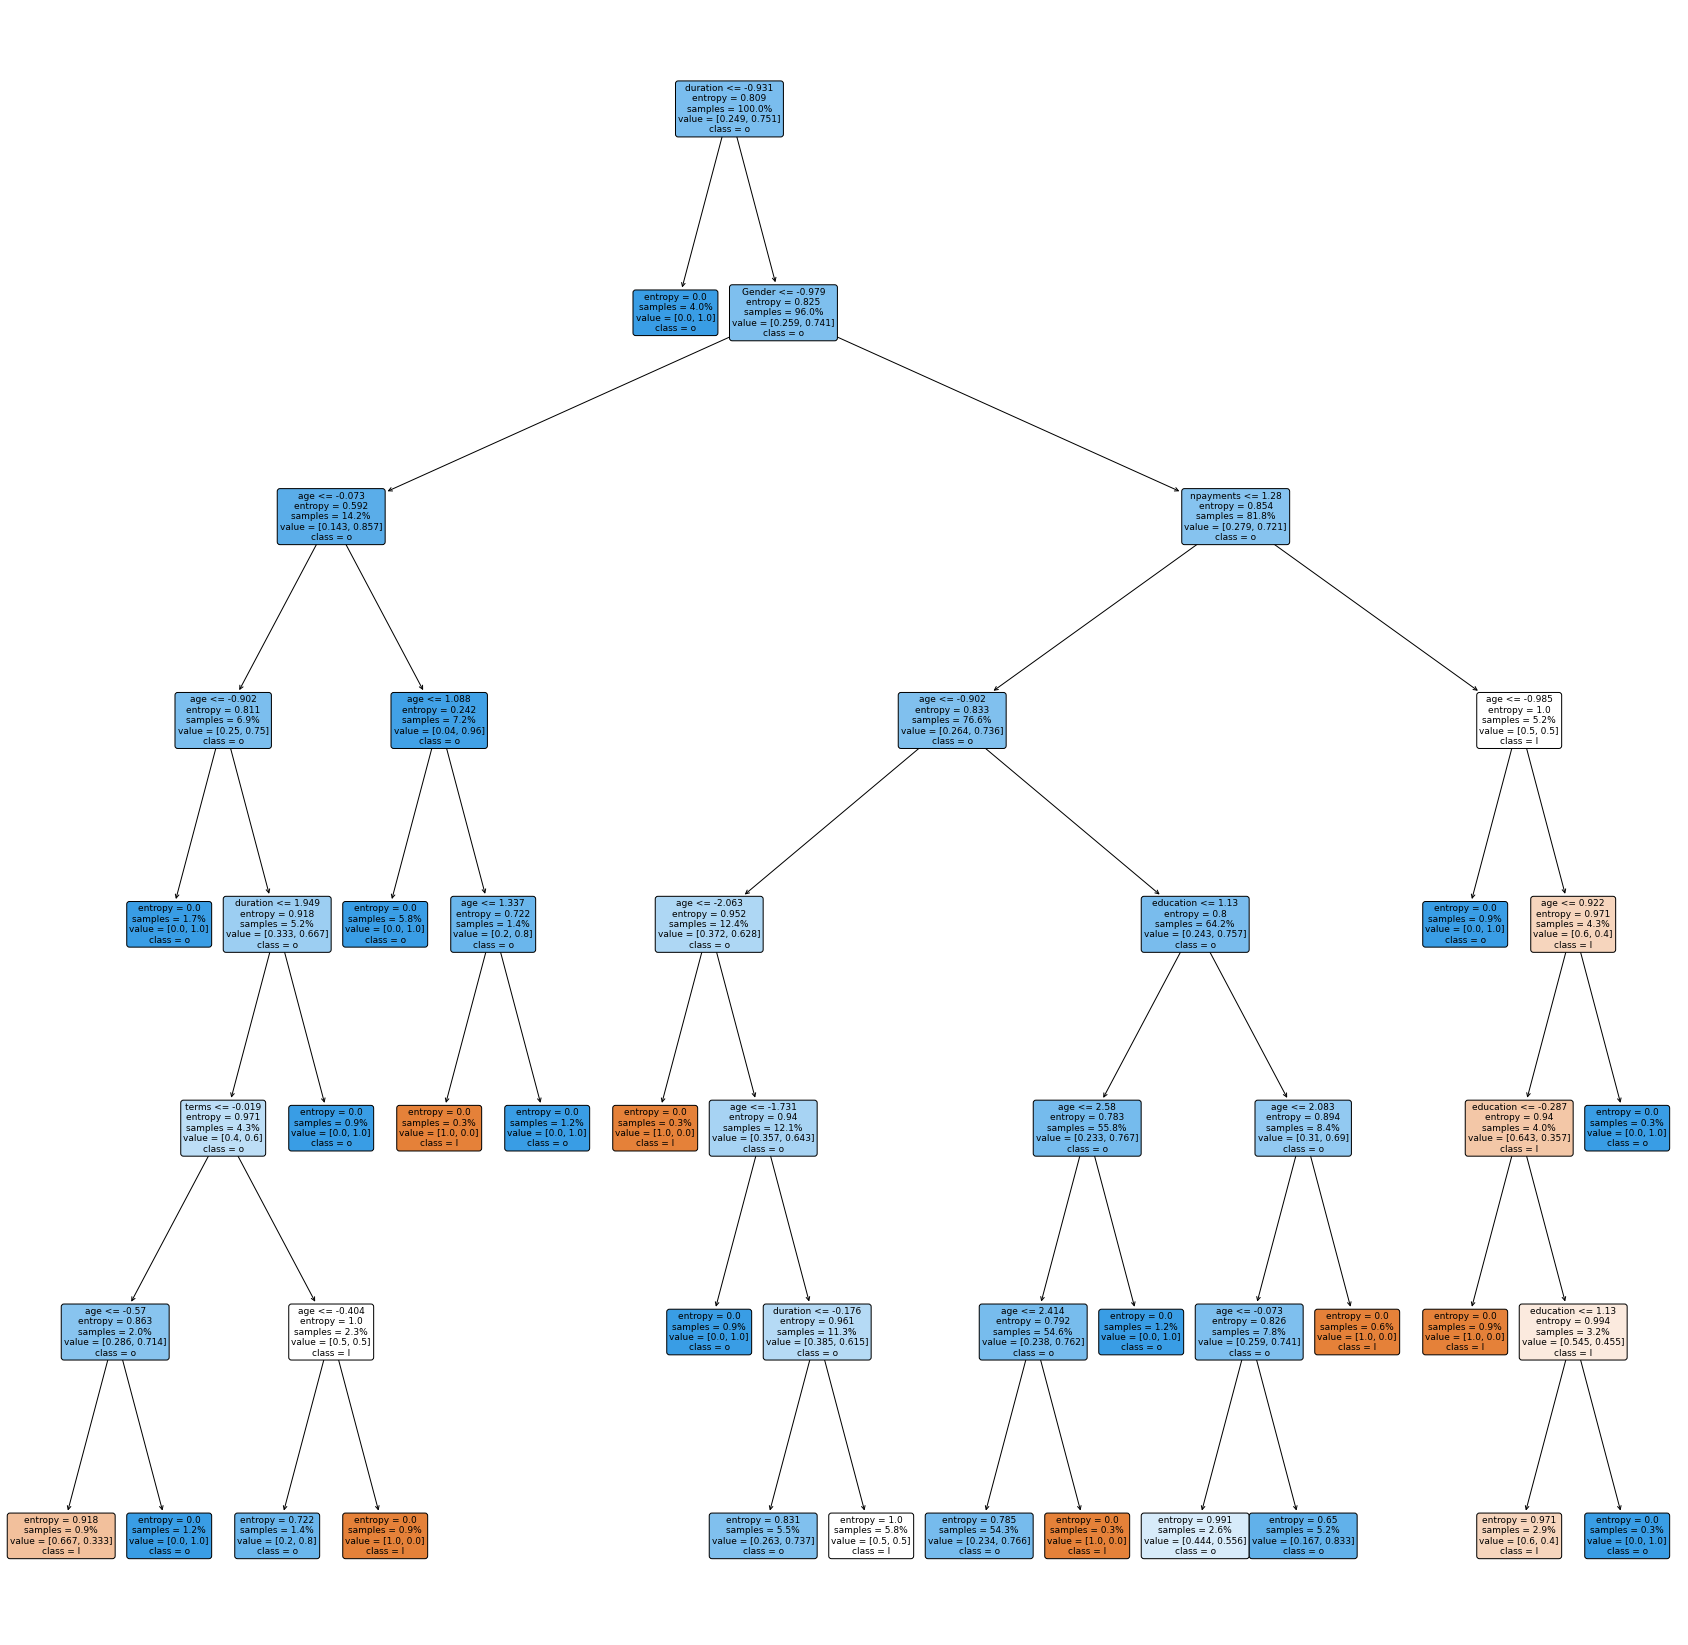

In [94]:
# Features and target sets
X = X_num
y = df.loan_status

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

# Buildi model for max_depth=7
clf_tree = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 7)
clf_tree = clf_tree.fit(X, y)
predTree = clf_tree.predict(X_test)


# Accuracy metrics
DT_accuracy = {'Jaccard'  : jaccard_score(y_test, predTree, pos_label='PAIDOFF'),
               'F1 score' : f1_score(y_test, predTree, pos_label='PAIDOFF'),
               'Log loss' : 'NA'}
print(DT_accuracy)

print("\nDecisionTrees's Test set Accuracy: ", metrics.accuracy_score(y_test, predTree))
print("DecisionTrees's Train set Accuracy: ", metrics.accuracy_score(y_train, clf_tree.predict(X_train)))

# Visualize tree
plt.figure(figsize=(30,30))
tree.plot_tree(clf_tree, filled=True, rounded=True, proportion=True, class_names='loan_status',feature_names=['Principal', 'terms', 'age', 'education', 'Gender', 'duration','npayments'])
plt.show()

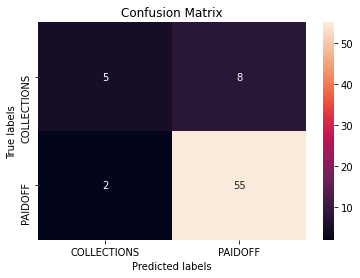

In [95]:
cm = confusion_matrix(y_test, predTree)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COLLECTIONS', 'PAIDOFF']); ax.yaxis.set_ticklabels(['COLLECTIONS', 'PAIDOFF']);

## Support Vector Machine

### Build model for several regularization parameters and kernels and choose best fit

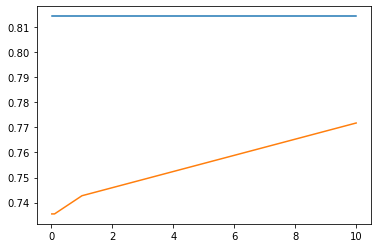

In [96]:
# Features and target set
X = X_num
y = y_num

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

# Iteration: build model with several regularization parameters
accuracy_test = []
accuracy_train = []

reg_param_values = [0.01,0.1,1,10]
for reg_param in reg_param_values:
    clf_svm = svm.SVC(C=reg_param, kernel='rbf')
    clf_svm.fit(X_train, y_train) 
    y_predictions = clf_svm.predict(X_test)
    accuracy_test.append(metrics.accuracy_score(y_test, y_predictions))
    accuracy_train.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))

# Visualize dependence of accucary w.r.t k
plt.plot(reg_param_values,accuracy_test)
plt.plot(reg_param_values,accuracy_train)

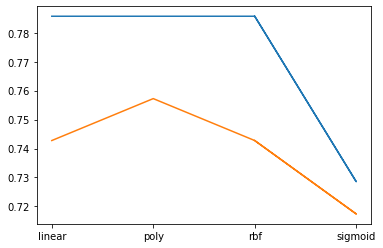

In [74]:
# Features and target set
X = X_num
y = y_num

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

# Iteration: build model with several regularization parameters
accuracy_test = []
accuracy_train = []

kernel_values = ['linear', 'poly', 'rbf', 'sigmoid', 'rbf']
for kernel in kernel_values:
    clf_svm = svm.SVC(C=1, kernel=kernel)
    clf_svm.fit(X_train, y_train) 
    y_predictions = clf_svm.predict(X_test)
    accuracy_test.append(metrics.accuracy_score(y_test, y_predictions))
    accuracy_train.append(metrics.accuracy_score(y_train, clf_svm.predict(X_train)))

# Visualize dependence of accucary w.r.t k
plt.plot(kernel_values,accuracy_test)
plt.plot(kernel_values,accuracy_train)

### Model and accuracy metrics for C=1 and kernel = 'poly'

In [97]:
# Features and target set
X = X_num
y = y_num

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

# Build model
clf_svm = svm.SVC(C=1, kernel='poly')
clf_svm.fit(X_train, y_train) 
y_predictions = clf_svm.predict(X_test)

# Accuracy metrics
SVM_accuracy = {'Jaccard'  : jaccard_score(y_test, y_predictions),
               'F1 score'  : f1_score(y_test, y_predictions, average='weighted'),
               'Log loss'  : 'NA'}
print(SVM_accuracy)

{'Jaccard': 0.8142857142857143, 'F1 score': 0.7309336332958379, 'Log loss': 'NA'}


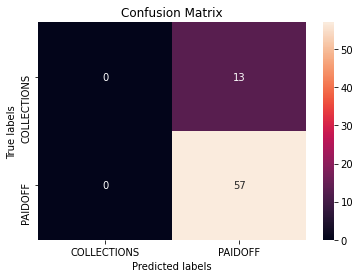

In [98]:
cm = confusion_matrix(y_test, y_predictions)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COLLECTIONS', 'PAIDOFF']); ax.yaxis.set_ticklabels(['COLLECTIONS', 'PAIDOFF']);

## Logistic Regression

Using liblinear solve and C=0.01

In [99]:
# Features and target set
X = X_num
y = y_num

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

# Build model
clf_lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
y_predictions = clf_lr.predict(X_test)
y_probabilities = clf_lr.predict_proba(X_test)

# Accuracy metrics
LR_accuracy = {'Jaccard'  : jaccard_score(y_test, y_predictions),
               'F1 score' : f1_score(y_test, y_predictions, average='weighted'),
               'Log loss' : log_loss(y_test, y_probabilities)}
print(LR_accuracy)

{'Jaccard': 0.8142857142857143, 'F1 score': 0.7309336332958379, 'Log loss': 0.5788913775893253}


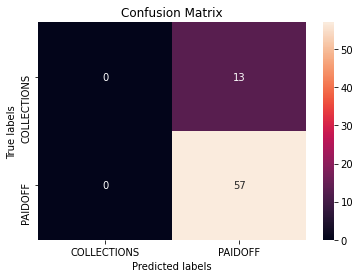

In [100]:
cm = confusion_matrix(y_test, y_predictions)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COLLECTIONS', 'PAIDOFF']); ax.yaxis.set_ticklabels(['COLLECTIONS', 'PAIDOFF']);

# Conclusion

The accuracy metrics obtained for each model are summarized in the following dataframe.

In [101]:
pd.DataFrame([KNN_accuracy,DT_accuracy,SVM_accuracy,LR_accuracy],index=['KNN','DecisionTree','SVM','LogisticRegression'])

,Jaccard,F1 score,Log loss
KNN,0.814286,0.897638,NA
DecisionTree,0.846154,0.916667,NA
SVM,0.814286,0.730934,NA
LogisticRegression,0.814286,0.730934,0.578891


The model that predicted less wrong payoffs was the decision tree, as shown by the confusion matrix; it is also the model with the highest Jaccard and F1 score, as seen in the table above. Yet, it is difficult to interpret this model with the large max_depth parameter chosen. Further analysis regarding the features chosen and its relation with the accuracy and predictions of the model would be necessary to grasp it. 

#  Observations

- Analysis of outliers was not performed.
- Impact of features on target needs to be studied, as well as correlations between features.
- High dependence on train-test split was observed.